## Portfolio Construction using Black-Litterman Model and Factors

By: Anjeshnu Trivedi

### 01 — Data Prep + CMA Priors


This notebook:

1) Loads daily adjusted close prices for the 7 ETFs and converts them into **monthly returns** (log returns).
2) Loads **Rates** (for T-Bill risk-free), **Macro**, and **Fama–French** factor datasets.
3) Extracts **BlackRock CMA 10Y USD** expected returns and volatilities from sheet Starting point scenario.
4) Maps CMA asset rows to ETFs and builds **prior excess returns** (CMA 10Y minus 10Y avg risk-free).

Outputs saved to `../outputs/`:
- returns_monthly.csv
- rf_monthly.csv
- macro_monthly.csv
- ff_factors_monthly.csv
- cma_priors_10y_usd.csv
- priors_mu_excess_annual.csv
- priors_vol_annual.csv


In [7]:
# --- CONFIG ---
from pathlib import Path
import pandas as pd
import numpy as np

DATA_DIR = Path("../data")
OUT_DIR  = Path("../outputs")
FIG_DIR  = Path("../results/figures")
OUT_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

ASSETS = ["SPY", "VGK", "EWJ", "FXI", "INDY", "EWZ", "IEF", "LQD", "DBC"]

# Black–Litterman parameter (tune later / sensitivity section)
TAU = 0.05

FILE_ETF   = DATA_DIR / "Raw_data_ETFs.xlsx"
FILE_RATES = DATA_DIR / "Rates.xlsx"
FILE_MACRO = DATA_DIR / "Macro_Factor_Data_extra.xlsx"
FILE_FF    = DATA_DIR / "Factor_Data.xlsx"
FILE_CMA   = DATA_DIR / "blackrock-capital-market-assumptions.xlsx"

LOOKBACK_YEARS = 15
PER_YEAR = 12  # monthly data

In [2]:
# Cleaning + ffill missing data
def clean_ffill_series(s: pd.Series) -> pd.Series:
    """Convert 0/invalid to NaN, then forward-fill."""
    s = pd.to_numeric(s, errors="coerce")
    s = s.replace(0, np.nan)
    return s.ffill()

def reindex_business_days(df: pd.DataFrame) -> pd.DataFrame:
    """Reindex to business-day calendar and forward-fill."""
    idx = pd.bdate_range(df.index.min(), df.index.max())
    return df.reindex(idx).ffill()

def load_yahoo_sheet_as_close(excel_path: Path, sheet_name: str) -> pd.Series:
    df = pd.read_excel(excel_path, sheet_name=sheet_name)
    df = df.rename(columns={df.columns[0]: "Date"})
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date").sort_index()

    # Prefer Adj Close if present, else Close
    px_col = "Adj Close" if "Adj Close" in df.columns else "Close"
    s = df[px_col].copy()

    s = clean_ffill_series(s)
    return s

In [3]:
def find_date_col(df):
    for c in df.columns:
        if "date" in str(c).lower():
            return c
    return df.columns[0]

def to_dt_index(df, date_col=None):
    df = df.copy()
    date_col = date_col or find_date_col(df)
    df[date_col] = pd.to_datetime(df[date_col])
    return df.set_index(date_col).sort_index()

def eom_prices(daily_px):
    return daily_px.resample("ME").last()

def monthly_returns(px_m, kind="log"):
    if kind == "log":
        return np.log(px_m).diff().dropna()
    if kind == "simple":
        return px_m.pct_change().dropna()
    raise ValueError("kind must be 'log' or 'simple'")

#### 1a) ETF prices -> monthly returns

In [4]:
def load_etf_prices_from_sheets():
    xls = pd.ExcelFile(FILE_ETF)
    # Expected sheet names like "SPY", "VGK", etc.
    ticker_to_sheet = {t: f"{t}" for t in ASSETS}

    px = {}
    for t, sh in ticker_to_sheet.items():
        if sh not in xls.sheet_names:
            raise ValueError(f"Missing sheet {sh} in {FILE_ETF.name}")
        px[t] = load_yahoo_sheet_as_close(FILE_ETF, sh)

    px_df = pd.concat(px, axis=1)
    px_df.columns = px_df.columns.get_level_values(0)

    # Reindex to business days + forward fill (fills missing dates)
    px_df = reindex_business_days(px_df)

    return px_df


etf_px_d = load_etf_prices_from_sheets()

# Visual “constituents” overview
# display(etf_px_d.tail())
# print("ETF daily date range:", etf_px_d.index.min(), "→", etf_px_d.index.max())
# print("Missing counts per ETF (after ffill):")
# print(etf_px_d.isna().sum())

# Monthly end-of-month prices and log returns
etf_px_m = etf_px_d.resample("ME").last()
etf_ret_m = np.log(etf_px_m).diff().dropna()

# display(etf_ret_m.tail())


#### 1b) Rates -> Monthly risk-free

In [5]:
# DGS3MO sheet has columns: observation_date, DGS3MO
dgs3mo = pd.read_excel(FILE_RATES)
dgs3mo["observation_date"] = pd.to_datetime(dgs3mo["observation_date"])
dgs3mo = dgs3mo.set_index("observation_date").sort_index()

rf_ann = clean_ffill_series(dgs3mo["DGS3MO"]) / 100.0   # DGS3MO is in percent
rf_ann = reindex_business_days(rf_ann.to_frame("RF_ANN"))["RF_ANN"]

# Convert annual % yield to monthly simple rate approximation
rf_m = (rf_ann / PER_YEAR).resample("ME").last().rename("RF_M")

# display(rf_m.tail())
# print("RF monthly range:", rf_m.index.min(), "→", rf_m.index.max())

#### 1c) Load Fama-French factor data (Monthly)

In [8]:
# Load Fama-French factor data from specified sheets
def load_ff_sheet(sheet_name: str) -> pd.DataFrame:
    df = pd.read_excel(FILE_FF, sheet_name=sheet_name)

    # Build datetime index from yyyymm
    df["Date"] = pd.to_datetime(df["yyyymm"].astype(int).astype(str), format="%Y%m") + pd.offsets.MonthEnd(0)
    df = df.set_index("Date").sort_index()

    # Keep only factor columns (in percent -> convert to decimals)
    cols = ["Mkt-RF","SMB","HML","RMW","CMA","MOM","RF"]
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{sheet_name} missing columns: {missing}")

    out = df[cols].apply(pd.to_numeric, errors="coerce") / 100.0
    return out

ff_us = load_ff_sheet("US")
ff_dev = load_ff_sheet("Devloped_exUS")
ff_em = load_ff_sheet("Emerging")

# Visual overview
# display(ff_us.tail())
# print("FF monthly range:", ff_us.index.min(), "→", ff_us.index.max())

ff_all = pd.concat(
    {
        "US": ff_us,
        "DEV": ff_dev,
        "EM": ff_em
    },
    axis=1
)

# Flatten columns: ("US","Mkt-RF") -> "US_Mkt-RF"
ff_all.columns = [f"{lvl0}_{lvl1}".replace("-", "_") for lvl0, lvl1 in ff_all.columns]
# display(ff_all.tail())


#### 1d) Extract CMA 10y USD and map to ETFs

CMA sheet: `Starting point scenario`.


["SPY", "VGK", "EWJ", "FXI", "INDY", "EWZ", "IEF", "LQD", "DBC"]
Mapping:
- SPY → US large cap equities (MSCI USA Index)
- VGK → Europe large cap equities (MSCI Europe index)
- EWJ → Japan large cap equities (MSCI Japan Index)
- FXI → China-Broad market (MSCI Emerging - China in CNY)
- INDY → India equities	(S&P India LargeCap Index)
- IEF → US government (10+ years)	(Bloomberg Barclays Long Goverment index)
- LQD → US credit (all maturities) (Bloomberg Barclays U.S. Credit Index)
- DBC → Based on subjective assumption

In [9]:
# --- Load BlackRock CMA (Starting point scenario) ---
cma_raw = pd.read_excel(FILE_CMA, sheet_name="Starting point scenario", header=None)

# Data starts at row 3 (0-based), where actual records begin.
# Headers in the file:
# 0 Currency, 1 Asset class, 2 Asset, 3 Index, 6 = 10y ER, 39 = Volatility (label is on row 1)
cma = cma_raw.iloc[3:].copy()
cma = cma.rename(columns={
    0: "Currency",
    1: "AssetClass",
    2: "Asset",
    3: "Index",
    6: "ER_10Y",
    39: "Vol"
})
cma = cma[["Currency", "AssetClass", "Asset", "Index", "ER_10Y", "Vol"]].copy()

# Clean types
cma["Currency"] = cma["Currency"].astype(str).str.strip()
cma["ER_10Y"] = pd.to_numeric(cma["ER_10Y"], errors="coerce")
cma["Vol"]    = pd.to_numeric(cma["Vol"], errors="coerce")

# --- Asset universe ---
ASSETS = ["SPY", "VGK", "EWJ", "FXI", "INDY", "EWZ", "IEF", "LQD", "DBC"]

# --- Static mapping: ETF -> (CMA Asset label, preferred currency list) ---
# Rule: Use USD first if present, otherwise fallback to "home" currency.
etf_cma_map = {
    "SPY":  ("US large cap equities", ["USD"]),
    "VGK":  ("Europe large cap equities", ["USD", "EUR"]),
    "EWJ":  ("Japan large cap equities", ["USD", "JPY"]),   # USD row not present; JPY exists
    "FXI":  ("China-Broad market", ["USD", "CNY", "CNH"]),  # USD exists
    "INDY": ("India equities", ["USD", "INR"]),             # USD not present; INR exists

    # Brazil is NOT in your CMA sheet -> map EWZ to EM equities as a proxy (explain in report)
    "EWZ":  ("Emerging large cap equities", ["USD"]),

    # Bonds: pick a Treasury proxy that does NOT include corporates (unlike AGG)
    # IEF (7–10y) is closest to "US government (all maturities)" or "US government (10+ years)"
    # Choose 10+ years if you want more duration sensitivity.
    "IEF":  ("US government (10+ years)", ["USD"]),  # alternative: "US government (10+ years)"
    "LQD":  ("US credit (all maturities)", ["USD"]),

    # Commodities are NOT present in this sheet -> return None
    "DBC":  (None, ["USD"]),
}

def pick_cma_row(asset_label, currency_pref):
    """Pick CMA row by trying currencies in order. asset_label must match exactly."""
    if asset_label is None:
        return None

    for cur in currency_pref:
        r = cma[(cma["Currency"].str.upper() == cur.upper()) & (cma["Asset"] == asset_label)]
        if not r.empty:
            return r.iloc[0]

    # fallback: any currency if none found
    r = cma[cma["Asset"] == asset_label]
    if not r.empty:
        return r.iloc[0]

    raise ValueError(f"Asset label not found in CMA sheet: '{asset_label}'")

# --- Build mapping table ---
rows = []
for etf in ASSETS:
    asset_label, cur_pref = etf_cma_map[etf]
    r = pick_cma_row(asset_label, cur_pref)

    if r is None:
        # e.g. DBC: not in CMA
        rows.append({
            "ETF": etf,
            "Currency_used": np.nan,
            "AssetClass": np.nan,
            "Asset": np.nan,
            "Index": np.nan,
            "ER_10Y": np.nan,
            "Vol": np.nan
        })
    else:
        rows.append({
            "ETF": etf,
            "Currency_used": r["Currency"],
            "AssetClass": r["AssetClass"],
            "Asset": r["Asset"],
            "Index": r["Index"],
            "ER_10Y": r["ER_10Y"],
            "Vol": r["Vol"]
        })

cma_etf = pd.DataFrame(rows).set_index("ETF")[["Currency_used","AssetClass","Asset","Index","ER_10Y","Vol"]]
# cma_etf

#### 1e) Build prior excess returns + add DBC priors

Subtract the **10-year average risk-free rate** (annualized) from CMA 10Y returns.
DBC priors subjectively chosen as 0.25%, volatility estimates manually set at last 5 years data.

In [10]:
# Align monthly index across ETF returns and rf
idx = etf_ret_m.index.intersection(rf_m.index)
etf_ret_m2 = etf_ret_m.loc[idx].copy()
rf_m2 = rf_m.loc[idx].copy()

# --- Risk-free rate (10Y average, annualized) ---
window_10y = LOOKBACK_YEARS * 12
rf10y_ann = float(rf_m2.iloc[-window_10y:].mean() * PER_YEAR)

# --- CMA priors (10Y) -> excess returns ---
mu_cma_excess = (cma_etf["ER_10Y"] - rf10y_ann)

# =========================
# Commodity (DBC) override
# =========================

# (1) Mean excess return: anchored at +0.25% annually
dbc_mu_excess_annual = 0.0025   # 0.25%

# (2) Volatility: estimated from last 5 years
window_5y = 5 * 12
dbc = etf_ret_m2["DBC"].dropna().iloc[-window_5y:]
dbc_vol_annual = float(dbc.std(ddof=1) * np.sqrt(PER_YEAR))

# --- Final prior vectors ---
mu_prior = mu_cma_excess.copy()
mu_prior.loc["DBC"] = dbc_mu_excess_annual
mu_prior = mu_prior.reindex(ASSETS).rename("mu_excess_annual")

vol_prior = cma_etf["Vol"].copy()
vol_prior.loc["DBC"] = dbc_vol_annual
vol_prior = vol_prior.reindex(ASSETS).rename("vol_annual")

# mu_prior, vol_prior


#### 1f) Save Data Preparation outputs

In [11]:
# Monthly common index
idx = etf_ret_m.index.intersection(rf_m.index).intersection(ff_all.index)

etf_ret_m2 = etf_ret_m.loc[idx].copy()
rf_m2 = rf_m.loc[idx].copy()
ff_all2 = ff_all.loc[idx].copy()

# Save
etf_ret_m2.to_csv(OUT_DIR / "returns_monthly.csv")
rf_m2.to_csv(OUT_DIR / "rf_monthly.csv")
ff_all2.to_csv(OUT_DIR / "ff_factors_monthly.csv")

cma_etf.to_csv(OUT_DIR / "cma_priors_10y_usd.csv")
mu_prior.to_csv(OUT_DIR / "priors_mu_excess_annual.csv")
vol_prior.to_csv(OUT_DIR / "priors_vol_annual.csv")

print("Saved outputs:",
      [p.name for p in OUT_DIR.glob("*.csv") if p.name.endswith(".csv")])


Saved outputs: ['cma_priors_10y_usd.csv', 'ff_factors_monthly.csv', 'priors_mu_excess_annual.csv', 'priors_vol_annual.csv', 'returns_monthly.csv', 'rf_monthly.csv']


### 02) Factor Model Covariance


Build the risky-asset covariance matrix Σ using:

1) Factor-model covariance (hybrid factors):
- FF: MKT_RF, SMB, RMW, CMA, HML, MOM (monthly)
- TERM: monthly change in 10Y yield
- CREDIT: LQD − AGG (monthly)
- COM: DBC return (monthly)

2) Ledoit–Wolf shrinkage covariance (robustness)

Outputs:
- Sigma_factor_annual.csv
- Sigma_lw_annual.csv
- B_exposures.csv
- factors_used_monthly.csv

In [12]:
# Load saved outputs to verify
rets = pd.read_csv(OUT_DIR / "returns_monthly.csv", index_col=0, parse_dates=True)[ASSETS]
rf   = pd.read_csv(OUT_DIR / "rf_monthly.csv", index_col=0, parse_dates=True).iloc[:,0]
ff   = pd.read_csv(OUT_DIR / "ff_factors_monthly.csv", index_col=0, parse_dates=True)

# Load Rates.xlsx directly for DGS10 (TERM proxy)
FILE_RATES = DATA_DIR / "Rates.xlsx"

print("Returns cols:", list(rets.columns))
print("RF name:", rf.name, "range:", rf.index.min(), "→", rf.index.max())
print("FF cols (sample):", list(ff.columns)[:8], "... total:", len(ff.columns))

# display(rets.tail())
# display(ff.tail())


Returns cols: ['SPY', 'VGK', 'EWJ', 'FXI', 'INDY', 'EWZ', 'IEF', 'LQD', 'DBC']
RF name: RF_M range: 2009-12-31 00:00:00 → 2025-11-30 00:00:00
FF cols (sample): ['US_Mkt_RF', 'US_SMB', 'US_HML', 'US_RMW', 'US_CMA', 'US_MOM', 'US_RF', 'DEV_Mkt_RF'] ... total: 21


#### 2a) Map factors

In [13]:
# ---- Choose universe ----
UNIVERSE = "US"   # "US" (recommended), or "DEV", or "EM"

FF_COLS = [f"{UNIVERSE}_Mkt_RF",
           f"{UNIVERSE}_SMB",
           f"{UNIVERSE}_HML",
           f"{UNIVERSE}_RMW",
           f"{UNIVERSE}_CMA",
           f"{UNIVERSE}_MOM"]

missing = [c for c in FF_COLS if c not in ff.columns]
if missing:
    raise ValueError(f"Missing expected FF columns: {missing}. Check ff_factors_monthly.csv columns.")

ff_used = ff[FF_COLS].copy()

# Optional: rename to cleaner names for later
ff_used.columns = ["MKT_RF","SMB","HML","RMW","CMA","MOM"]

# display(ff_used.tail())


#### 2b) Build Term / Credit / COM factors

In [14]:
# Load DGS10 daily from Rates.xlsx sheet "DGS10"
dgs10 = pd.read_excel(FILE_RATES)

# Expected columns: observation_date, DGS10
dgs10["observation_date"] = pd.to_datetime(dgs10["observation_date"])
dgs10 = dgs10.set_index("observation_date").sort_index()

y10 = pd.to_numeric(dgs10["DGS10"], errors="coerce")

# DGS10 is typically in percent → convert to decimal
y10 = (y10 / 100.0).ffill()

# Convert daily yield level to end-of-month yield level
y10_m = y10.resample("ME").last()

# TERM factor = monthly change in 10y yield (decimal)
TERM = y10_m.diff().rename("TERM")

# display(TERM.tail())

# CREDIT and COM factors
CREDIT = (rets["LQD"] - rets["IEF"]).rename("CREDIT")
COM = rets["DBC"].rename("COM")

# Combine factors and align dates cleanly
# Combine factor set (monthly)
F = pd.concat([ff_used, TERM, CREDIT, COM], axis=1)

# Align to dates present in returns and rf
idx = rets.index.intersection(rf.index).intersection(F.index)

R = rets.loc[idx].copy()
rf2 = rf.loc[idx].copy()
F = F.loc[idx].copy()

# Excess returns for regression
R_ex = R.sub(rf2, axis=0)

# Drop any rows with NaNs created by TERM diff or missing data
valid_idx = F.dropna().index.intersection(R_ex.dropna().index)
F = F.loc[valid_idx]
R_ex = R_ex.loc[valid_idx]
R = R.loc[valid_idx]

print("Shapes -> F:", F.shape, "| R_ex:", R_ex.shape)
# display(F.tail())

# Save factors used
F.to_csv(OUT_DIR / "factors_used_monthly.csv")
print("Saved factors_used_monthly.csv with columns:", list(F.columns))

Shapes -> F: (192, 9) | R_ex: (192, 9)
Saved factors_used_monthly.csv with columns: ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'TERM', 'CREDIT', 'COM']


#### 2c) Estimate exposures and build factor-model Σ

In [15]:
import statsmodels.api as sm

B = pd.DataFrame(index=ASSETS, columns=F.columns, dtype=float)
resid_var = pd.Series(index=ASSETS, dtype=float)

for a in ASSETS:
    y = R_ex[a].dropna()
    X = sm.add_constant(F.loc[y.index])
    m = sm.OLS(y, X).fit()
    B.loc[a] = m.params.drop("const")
    resid_var[a] = np.var(m.resid, ddof=int(m.df_model)+1)

F_cov_a = F.cov() * PER_YEAR
D_a = np.diag(resid_var.values * PER_YEAR)

Sigma_factor = B.values @ F_cov_a.values @ B.values.T + D_a
Sigma_factor = pd.DataFrame(Sigma_factor, index=ASSETS, columns=ASSETS)
# Sigma_factor

#### 2d) Shrinkage covariance (Ledoit-Wolf)

In [16]:
from sklearn.covariance import LedoitWolf

lw = LedoitWolf().fit(R.values)
Sigma_lw = pd.DataFrame(lw.covariance_ * PER_YEAR, index=ASSETS, columns=ASSETS)
# Sigma_lw

**Plotting Correlations and covariance heatmaps**

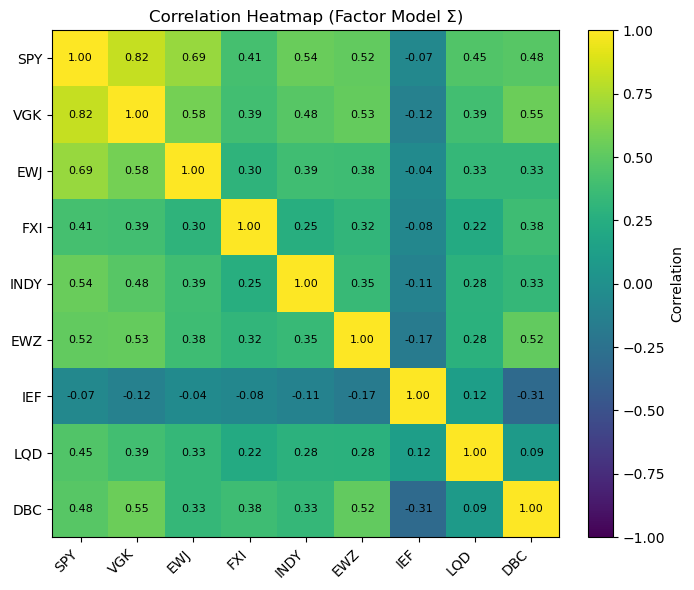

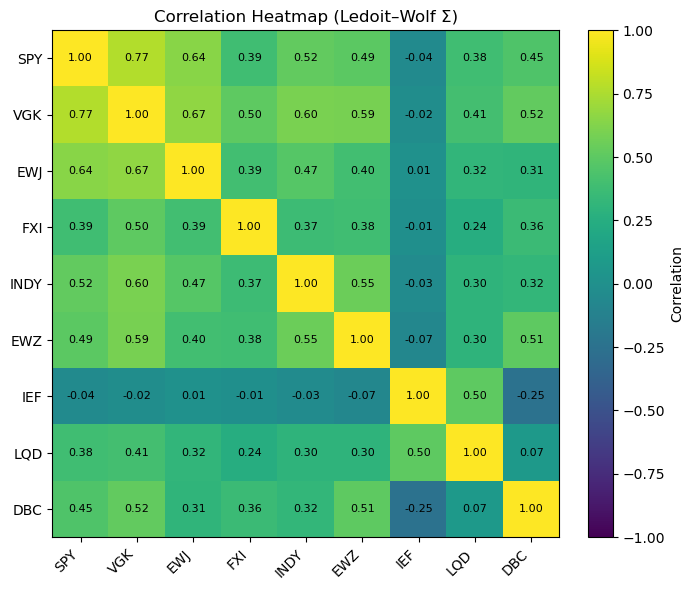

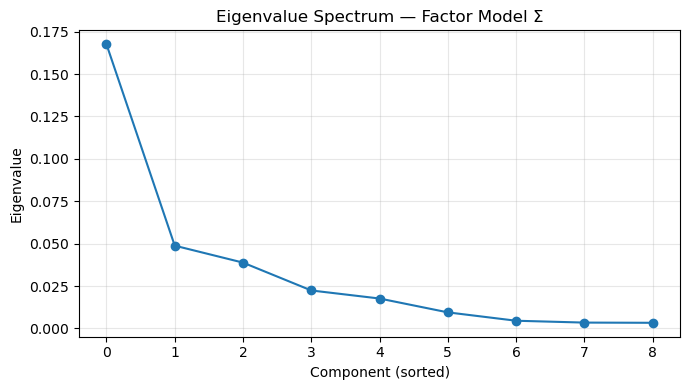

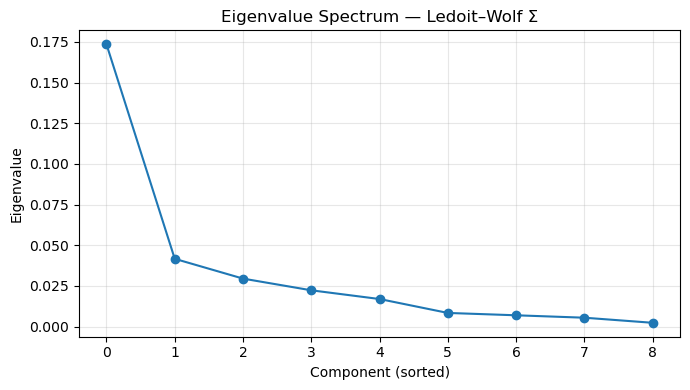

In [17]:
# Covar to correlation
def cov_to_corr(Sigma: pd.DataFrame) -> pd.DataFrame:
    d = np.sqrt(np.diag(Sigma))
    corr = Sigma.values / np.outer(d, d)
    return pd.DataFrame(corr, index=Sigma.index, columns=Sigma.columns)

# Plot correlation heatmaps
import matplotlib.pyplot as plt

def plot_corr_heatmap(Sigma: pd.DataFrame, title: str):
    corr = cov_to_corr(Sigma)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(corr.values, vmin=-1, vmax=1)  # default colormap is fine

    ax.set_xticks(range(len(corr.columns)))
    ax.set_xticklabels(corr.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(corr.index)))
    ax.set_yticklabels(corr.index)

    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label("Correlation")

    # add values (optional)
    for i in range(corr.shape[0]):
        for j in range(corr.shape[1]):
            ax.text(j, i, f"{corr.values[i,j]:.2f}", ha="center", va="center", fontsize=8)

    plt.tight_layout()
    plt.show()

plot_corr_heatmap(Sigma_factor, "Correlation Heatmap (Factor Model Σ)")
plot_corr_heatmap(Sigma_lw, "Correlation Heatmap (Ledoit–Wolf Σ)")

# Eigenvalue spectrum (risk concentration)
def plot_eigen_spectrum(Sigma: pd.DataFrame, title: str):
    eigvals = np.linalg.eigvalsh(Sigma.values)
    eigvals = np.sort(eigvals)[::-1]

    fig, ax = plt.subplots(figsize=(7, 4))
    ax.plot(eigvals, marker="o")
    ax.set_title(title)
    ax.set_xlabel("Component (sorted)")
    ax.set_ylabel("Eigenvalue")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_eigen_spectrum(Sigma_factor, "Eigenvalue Spectrum — Factor Model Σ")
plot_eigen_spectrum(Sigma_lw, "Eigenvalue Spectrum — Ledoit–Wolf Σ")


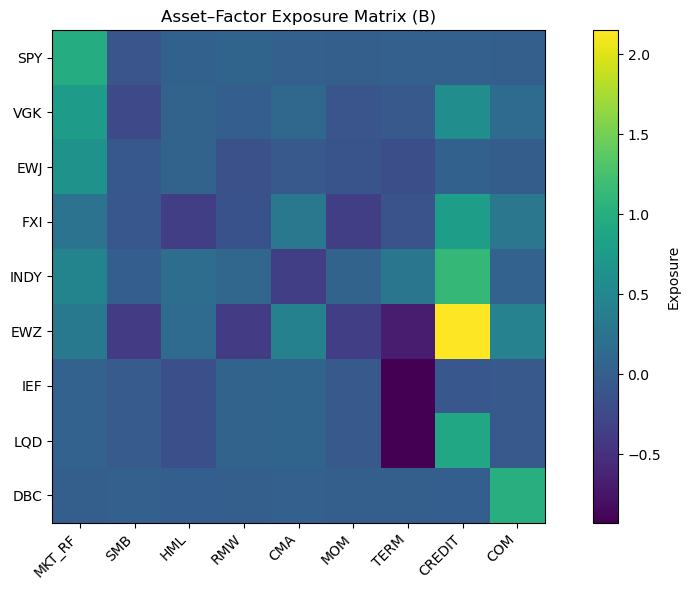

In [18]:
# visualize asset–factor relationships
import matplotlib.pyplot as plt

def plot_factor_exposures(B: pd.DataFrame, title: str):
    fig, ax = plt.subplots(figsize=(10, 6))
    im = ax.imshow(B.values)

    ax.set_xticks(range(len(B.columns)))
    ax.set_xticklabels(B.columns, rotation=45, ha="right")
    ax.set_yticks(range(len(B.index)))
    ax.set_yticklabels(B.index)

    ax.set_title(title)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Exposure")

    plt.tight_layout()
    plt.show()

plot_factor_exposures(B, "Asset–Factor Exposure Matrix (B)")


Using window: 2010-12-31 to 2025-12-31  |  n=181 months


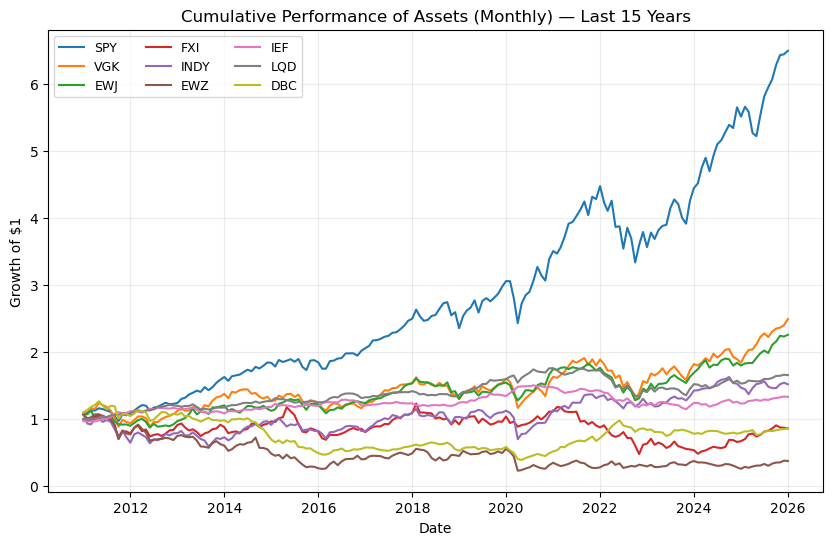

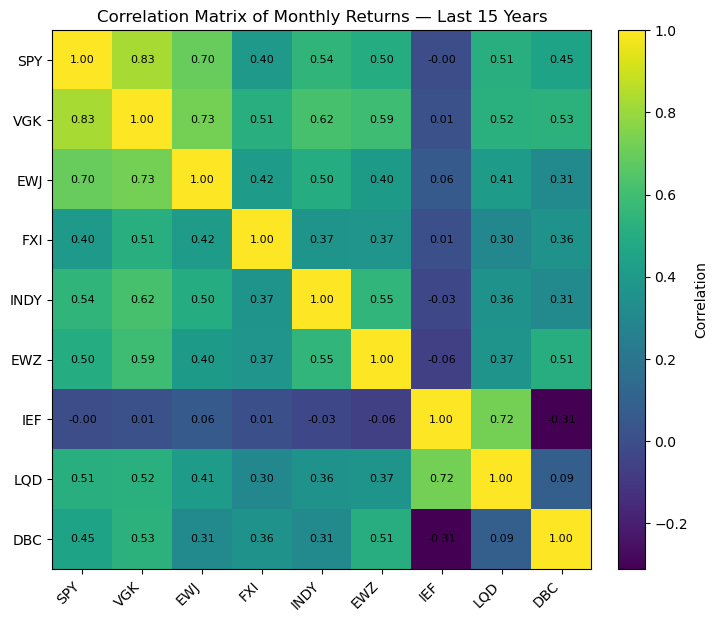

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Inputs ---
ASSETS = ["SPY", "VGK", "EWJ", "FXI", "INDY", "EWZ", "IEF", "LQD", "DBC"]
LOOKBACK_YEARS = 15
PER_YEAR = 12

# monthly returns DataFrame (simple returns, not log)
R_m = etf_ret_m[ASSETS].copy()  # <-- change to your monthly returns df if needed
R_m = R_m.dropna(how="all")

# --- 15-year lookback window (based on last available date) ---
end_dt = R_m.index.max()
start_dt = end_dt - pd.DateOffset(years=LOOKBACK_YEARS)
R_15 = R_m.loc[R_m.index >= start_dt].dropna()

print(f"Using window: {R_15.index.min().date()} to {R_15.index.max().date()}  |  n={len(R_15)} months")

def save_fig(fig, name, dpi=300):
    """
    Save matplotlib figure as PNG and PDF.
    name: file name without extension (e.g. 'fig_2_1_returns')
    """
    fig.savefig(FIG_DIR / f"{name}.png", dpi=dpi, bbox_inches="tight")
    #fig.savefig(FIG_DIR / f"{name}.pdf", bbox_inches="tight")

# =========================
# Figure 2.1: Cumulative returns (Growth of $1)
# =========================
growth = (1.0 + R_15).cumprod()

fig, ax = plt.subplots(figsize=(10, 6))

for a in ASSETS:
    if a in growth.columns:
        ax.plot(growth.index, growth[a], label=a)

ax.set_title(f"Cumulative Performance of Assets (Monthly) — Last {LOOKBACK_YEARS} Years")
ax.set_xlabel("Date")
ax.set_ylabel("Growth of $1")
ax.legend(ncols=3, fontsize=9)
ax.grid(True, alpha=0.25)

save_fig(fig, "fig_2_1_cumulative_returns")

plt.show()

# =========================
# Figure 2.2: Correlation heatmap (monthly)
# =========================
corr = R_15.corr()

fig, ax = plt.subplots(figsize=(8.5, 7))

im = ax.imshow(corr.values)

ax.set_xticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns, rotation=45, ha="right")
ax.set_yticks(range(len(corr.index)))
ax.set_yticklabels(corr.index)

ax.set_title(f"Correlation Matrix of Monthly Returns — Last {LOOKBACK_YEARS} Years")

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Correlation")

for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr.iloc[i, j]:.2f}", ha="center", va="center", fontsize=8)

save_fig(fig, "fig_2_2_correlation_heatmap")

plt.show()


#### 2e) Saving outputs from factor and covariances

In [20]:
B.to_csv(OUT_DIR / "B_exposures.csv")
F.to_csv(OUT_DIR / "factors_used_monthly.csv")
Sigma_factor.to_csv(OUT_DIR / "Sigma_factor_annual.csv")
Sigma_lw.to_csv(OUT_DIR / "Sigma_lw_annual.csv")

print("Saved:", [p.name for p in OUT_DIR.glob("Sigma_*")])

Saved: ['Sigma_factor_annual.csv', 'Sigma_lw_annual.csv']


#### 2f) Factor backtesting

In [21]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

PER_YEAR = 12
FACTOR_COLS = ['MKT_RF', 'SMB', 'HML', 'RMW', 'CMA', 'MOM', 'TERM', 'CREDIT', 'COM']

# Ensure alignment and drop missing
F_bt = F[FACTOR_COLS].dropna().copy()

def ann_return(r): return float(r.mean() * PER_YEAR)
def ann_vol(r):    return float(r.std(ddof=1) * np.sqrt(PER_YEAR))
def sharpe(r):
    v = ann_vol(r)
    return np.nan if v == 0 else ann_return(r) / v

def cum_index(r):  return (1.0 + r).cumprod()

# --- Table: factor summary ---
factor_summary = pd.DataFrame({
    "Ann.Return": [ann_return(F_bt[c]) for c in FACTOR_COLS],
    "Ann.Vol":    [ann_vol(F_bt[c]) for c in FACTOR_COLS],
    "Sharpe":     [sharpe(F_bt[c]) for c in FACTOR_COLS]
}, index=FACTOR_COLS).sort_values("Sharpe", ascending=False)


factor_summary.to_csv(OUT_DIR / "factors_summ.csv")
#factor_summary


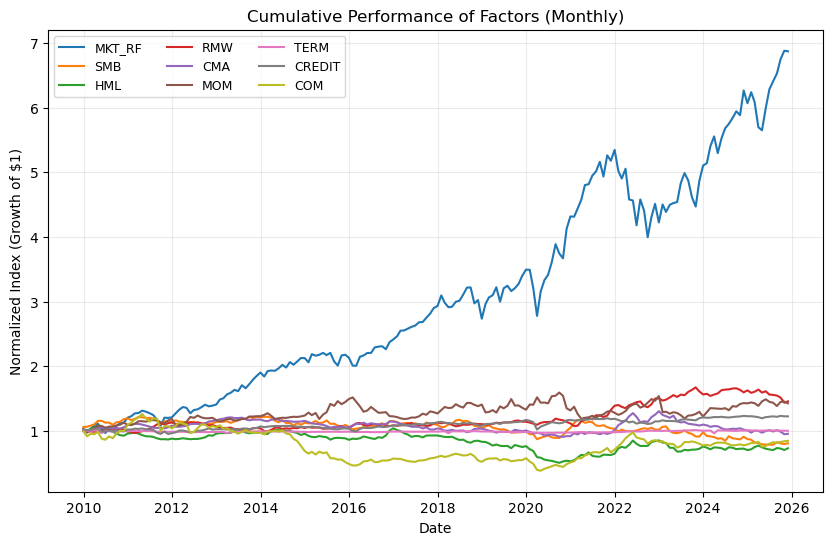

In [22]:
# --- Figure: cumulative factor performance ---
fig, ax = plt.subplots(figsize=(10, 6))

for c in FACTOR_COLS:
    ax.plot(cum_index(F_bt[c]), label=c)

ax.set_title("Cumulative Performance of Factors (Monthly)")
ax.set_xlabel("Date")
ax.set_ylabel("Normalized Index (Growth of $1)")
ax.legend(ncols=3, fontsize=9)
ax.grid(True, alpha=0.25)

# Save figure
save_fig(fig, "fig_3_1_cumulative_factor_performance")

plt.show()

In [23]:
mkt = F_bt["MKT_RF"].dropna()

rows = []
for c in FACTOR_COLS:
    if c == "MKT_RF":
        continue
    y = F_bt[c].dropna()
    idx = y.index.intersection(mkt.index)
    y = y.loc[idx]
    X = sm.add_constant(mkt.loc[idx])
    res = sm.OLS(y.values, X.values).fit()

    rows.append({
        "Factor": c,
        "Alpha (monthly)": float(res.params[0]),
        "Alpha (annual)":  float(res.params[0] * PER_YEAR),
        "Beta to MKT":     float(res.params[1]),
        "t(alpha)":        float(res.tvalues[0]),
        "t(beta)":         float(res.tvalues[1]),
        "R2":              float(res.rsquared),
    })

factor_vs_mkt = pd.DataFrame(rows).set_index("Factor").sort_values("R2", ascending=False)
factor_vs_mkt.to_csv(OUT_DIR / "factors_vs_mkt.csv")


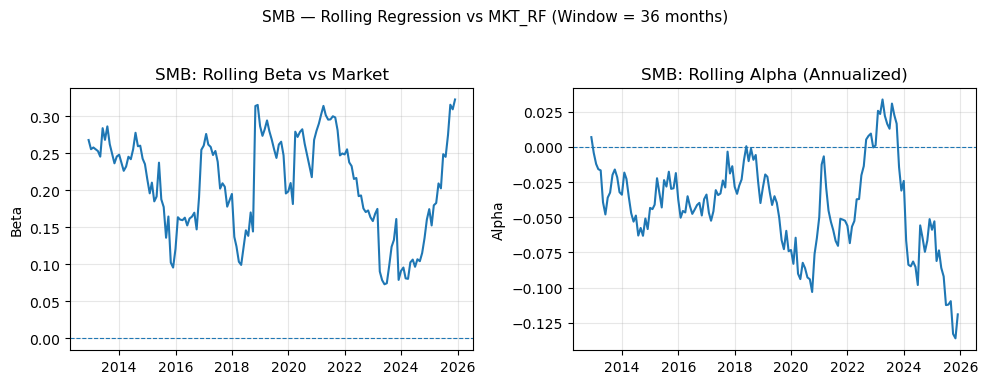

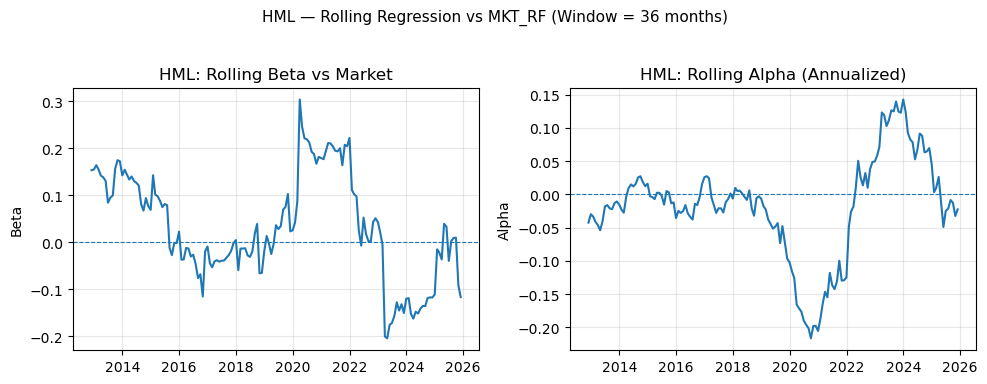

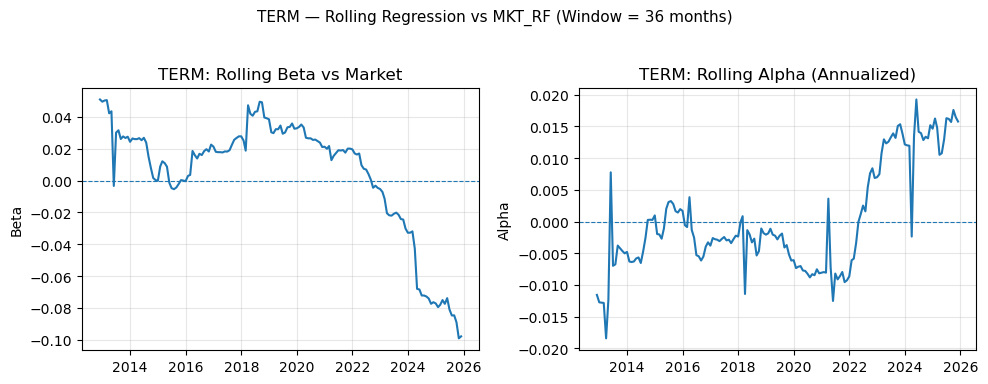

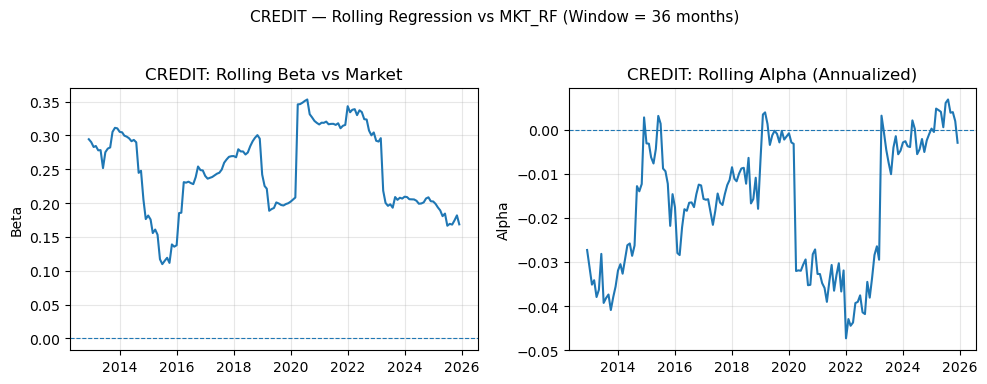

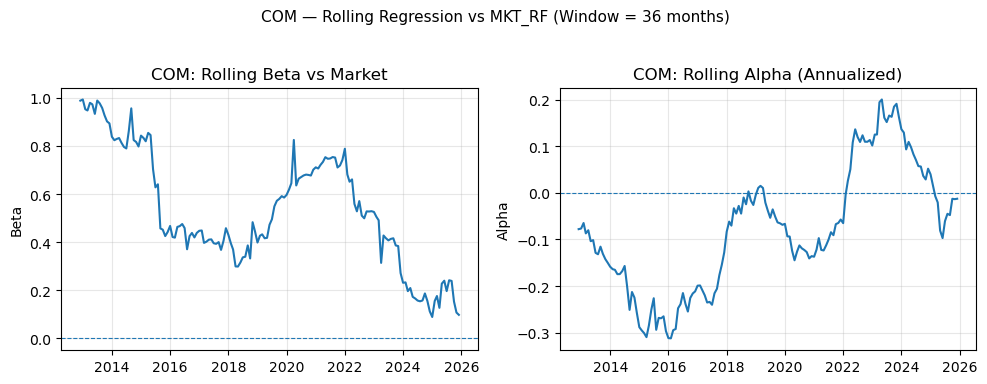

In [24]:
# Rolling OLS function for Alpha and Beta over time for each factor vs MKT_RF
def rolling_ols(y, x, window=36):
    y = y.dropna()
    x = x.reindex(y.index).dropna()
    idx = y.index.intersection(x.index)
    y = y.loc[idx]
    x = x.loc[idx]

    alphas, betas, dates = [], [], []
    for i in range(window, len(idx) + 1):
        t_idx = idx[i-window:i]
        Y = y.loc[t_idx].values
        X = sm.add_constant(x.loc[t_idx].values)
        res = sm.OLS(Y, X).fit()
        alphas.append(res.params[0])
        betas.append(res.params[1])
        dates.append(t_idx[-1])

    return pd.DataFrame({"alpha": alphas, "beta": betas}, index=pd.to_datetime(dates))

ROLLING_WINDOW = 36
key_rolling = ["SMB", "HML", "TERM", "CREDIT", "COM"]
key_rolling = [c for c in key_rolling if c in FACTOR_COLS]

for c in key_rolling:
    rr = rolling_ols(F[c], F["MKT_RF"], window=ROLLING_WINDOW)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

    # --- Rolling Beta ---
    axes[0].plot(rr.index, rr["beta"])
    axes[0].axhline(0, linestyle="--", linewidth=0.8)
    axes[0].set_title(f"{c}: Rolling Beta vs Market")
    axes[0].set_ylabel("Beta")
    axes[0].grid(True, alpha=0.3)

    # --- Rolling Alpha (annualized) ---
    axes[1].plot(rr.index, rr["alpha"] * PER_YEAR)
    axes[1].axhline(0, linestyle="--", linewidth=0.8)
    axes[1].set_title(f"{c}: Rolling Alpha (Annualized)")
    axes[1].set_ylabel("Alpha")
    axes[1].grid(True, alpha=0.3)

    fig.suptitle(f"{c} — Rolling Regression vs MKT_RF (Window = {ROLLING_WINDOW} months)",
                 fontsize=11)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

    plt.show()


### 03) Black-Litterman Posterior

Compute Black–Litterman posterior expected returns.

Inputs:
- Sigma_factor_annual.csv (02)
- priors_mu_excess_annual.csv (01)  ← CMA 10Y USD excess priors
- Your benchmark weights w_mkt (73% equity, 23% FI, 4% commodities)

Outputs:
- lambda_implied.txt
- pi_equilibrium.csv
- mu_bl_posterior.csv
- Sigma_bl_annual.csv
- views_P.csv / views_Q.csv / views_Omega.csv


#### 3a) Load Σ and CMA priors (excess annual)

In [25]:
Sigma = pd.read_csv(OUT_DIR / "Sigma_factor_annual.csv", index_col=0).loc[ASSETS, ASSETS]
mu_prior = pd.read_csv(OUT_DIR / "priors_mu_excess_annual.csv", header=None, index_col=0).iloc[:,0].reindex(ASSETS).astype(float)

# Sigma, mu_prior

#### 3b) Define w_mkt (refernce portfolio)

Broader Allocation split in Equities 73%, Fixed Income 23% and Commodity 4%.

Within each sleeve:

Equities -> Split based on Market capitalization of the underlying Indices.

Bonds -> Split between 2 indices equally.


In [26]:
w_mkt = pd.Series({
    "SPY": 0.532, "VGK": 0.106, "EWJ": 0.044, "FXI": 0.020, "INDY": 0.023, "EWZ": 0.005,  # equities sum 0.73
    "IEF": 0.115, "LQD": 0.115,                                                       # FI sum 0.23
    "DBC": 0.04                                                                       # commodities sum 0.04
}).reindex(ASSETS)

if abs(w_mkt.sum() - 1) > 1e-8:
    raise ValueError("w_mkt must sum to 1.")
# w_mkt

#### 3c) Implied risk aversion λ and equilibrium Π

In [27]:
w = w_mkt.values
S = Sigma.values
mu = mu_prior.values

lambda_imp = float((w @ mu) / (w @ S @ w))
Pi = lambda_imp * S @ w

print("Implied Risk aversion: " + str(lambda_imp))
print("Implied Risk Premiums:")
pd.Series(Pi, index=ASSETS)

Implied Risk aversion: 2.926155896760667
Implied Risk Premiums:


SPY     0.045193
VGK     0.049821
EWJ     0.032606
FXI     0.034977
INDY    0.039523
EWZ     0.057688
IEF    -0.000428
LQD     0.012419
DBC     0.029015
dtype: float64

#### 3d) Define views (P, Q) and Ω

**Proposed Black–Litterman Views (AI Boom Scenario)**

The Black–Litterman views implemented in this study are motivated by a growth-led
“AI boom” scenario consistent with BlackRock’s macro outlook. The scenario assumes
above-trend productivity growth driven by artificial intelligence adoption, with
uneven benefits across regions and asset classes.

All views are expressed in **relative excess return form** to improve robustness and
reduce sensitivity to absolute return forecasts. View magnitudes are specified on
an **annual basis** and are deliberately moderate to reflect uncertainty in macro
transmission mechanisms.


| View | Economic Interpretation | Mathematical Representation | Implied Excess Return (Q) |
|------|-------------------------|-----------------------------|---------------------------|
| V1 | Emerging market equities outperform U.S. equities | (INDY + FXI + EWZ) / 3 − SPY | +1.5% |
| V2 | U.S. equities outperform European equities | SPY − VGK | +1.0% |
| V3 | Japanese equities outperform European equities | EWJ − VGK | +0.75% |
| V4 | Investment-grade credit outperforms government bonds | LQD − IEF | +0.75% |
| V5 | Equities outperform bonds | Equity basket − Bond basket | +1.25% |
| V6 | Commodities outperform government bonds | DBC − (IEF + LQD) / 2 | +1.5% |
| V7 | Brazilian equities outperform Chinese equities | EWZ − FXI | +0.25% |

These views jointly ensure that all assets in the portfolio are influenced either
directly or indirectly, while maintaining economic consistency with the underlying
macro scenario.


In [28]:
import numpy as np

# Asset order must match everywhere
ASSETS = ["SPY", "VGK", "EWJ", "FXI", "INDY", "EWZ", "IEF", "LQD", "DBC"]

def build_views_PQ(assets):
    P = pd.DataFrame([
        # SPY  VGK  EWJ  FXI  INDY EWZ  IEF  LQD  DBC
        [-1.0, 0.0, 0.0, 0.33, 0.33, 0.33, 0.0, 0.0, 0.0],   # V1: EM > US
        [ 1.0,-1.0, 0.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0],   # V2: US > Europe
        [ 0.0,-1.0, 1.0, 0.0,  0.0,  0.0, 0.0, 0.0, 0.0],   # V3: Japan > Europe
        [ 0.0, 0.0, 0.0, 0.0,  0.0,  0.0,-1.0, 1.0, 0.0],   # V4: Credit > Duration
        [ 0.2, 0.2, 0.2, 0.2,  0.2,  0.2,-0.5,-0.5, 0.0],   # V5: Equities > Bonds
        [ 0.0, 0.0, 0.0, 0.0,  0.0,  0.0,-0.5,-0.5, 1.0],   # V6: Commodities > Bonds
        [ 0.0, 0.0, 0.0,-1.0,  0.0,  1.0, 0.0, 0.0, 0.0],   # V7: Brazil > China
    ], columns=assets)

    Q = pd.Series(
        [0.015, 0.01, 0.0075, 0.0075, 0.0125, 0.015, 0.0025],
        index=[
            "V1_EM_vs_US",
            "V2_US_vs_Europe",
            "V3_Japan_vs_Europe",
            "V4_Credit_vs_Duration",
            "V5_Equities_vs_Bonds",
            "V6_Commodities_vs_Bonds",
            "V7_Brazil_vs_China",
        ],
        name="Q_annual_excess"
    )

    P.index = Q.index
    return P, Q


def omega_idzorek(P, Sigma, tau, conf):
    """
    Idzorek-style Omega:
      Omega_ii = ((1-c)/c) * (p_i' (tau Sigma) p_i)
    where c is confidence in (0,1).
    
    Works whether P is a DataFrame or ndarray.
    Sigma is (N x N) in annual units.
    """
    Pm = P.values if isinstance(P, pd.DataFrame) else np.asarray(P)
    S = np.asarray(Sigma)
    conf = np.asarray(conf).reshape(-1)

    if Pm.shape[0] != conf.shape[0]:
        raise ValueError("conf length must equal number of views (rows in P).")

    Omega = np.zeros((Pm.shape[0], Pm.shape[0]))
    for i in range(Pm.shape[0]):
        p = Pm[i:i+1, :]
        var_view = p @ (tau * S) @ p.T   # 1x1 array
        Omega[i, i] = ((1 - conf[i]) / conf[i]) * var_view.item()
    return Omega


# ---- Build views ----
P, Q = build_views_PQ(ASSETS)

conf = np.array([
    0.55,  # EM catch-up (structural but uncertain)
    0.70,  # US vs Europe (high confidence)
    0.60,  # Japan reform
    0.75,  # Credit vs duration (high confidence)
    0.65,  # Equities vs bonds
    0.55,  # Commodities vs bonds
    0.55,  # Brazil vs China
])

Omega = omega_idzorek(P, S, TAU, conf)

# print("P:")
# display(P)
# print("\nQ:")
# display(Q)
print("\nOmega (diagonal):")
print(np.diag(Omega))


Omega (diagonal):
[0.00083283 0.00021832 0.00074538 0.00014455 0.00084422 0.00137656
 0.0045657 ]


#### 3e) BL Posterior

In [29]:
def black_litterman(Sigma, w_mkt, lambda_, P, Q, Omega, tau, assets=None):
    """
    Robust BL implementation:
    - Accepts Sigma as DataFrame or ndarray
    - Accepts P as DataFrame or ndarray
    - Accepts Q as Series or ndarray
    - Converts everything to numpy in a consistent ASSETS order
    """
    # --- Ensure consistent ordering ---
    if assets is not None:
        if isinstance(Sigma, pd.DataFrame):
            Sigma = Sigma.loc[assets, assets].values
        else:
            Sigma = np.asarray(Sigma)

        if isinstance(w_mkt, (pd.Series, pd.DataFrame)):
            w_mkt = np.asarray(w_mkt.reindex(assets)).reshape(-1)
        else:
            w_mkt = np.asarray(w_mkt).reshape(-1)

        if isinstance(P, pd.DataFrame):
            P = P.loc[:, assets].values
        else:
            P = np.asarray(P)

    else:
        Sigma = Sigma.values if isinstance(Sigma, pd.DataFrame) else np.asarray(Sigma)
        w_mkt = np.asarray(w_mkt).reshape(-1)
        P = P.values if isinstance(P, pd.DataFrame) else np.asarray(P)

    Q = Q.values if isinstance(Q, pd.Series) else np.asarray(Q).reshape(-1)
    Omega = np.asarray(Omega)

    # --- BL math ---
    Pi = lambda_ * Sigma @ w_mkt
    mid = np.linalg.inv(P @ (tau * Sigma) @ P.T + Omega)
    mu_bl = Pi + (tau * Sigma) @ P.T @ mid @ (Q - P @ Pi)

    Sigma_bl = Sigma + (tau * Sigma) - (tau * Sigma) @ P.T @ mid @ P @ (tau * Sigma)

    return Pi, mu_bl, Sigma_bl

Pi2, mu_bl, Sigma_bl = black_litterman(
    Sigma=Sigma_factor,     # or S (but better use the DF)
    w_mkt=w,                # your w_mkt vector/series
    lambda_=lambda_imp,
    P=P,
    Q=Q,
    Omega=Omega,
    tau=TAU,
    assets=ASSETS
)

mu_bl_s = pd.Series(mu_bl, index=ASSETS, name="mu_bl_excess_annual").sort_values(ascending=False)
mu_bl_s

# Pi2, mu_bl, Sigma_bl = black_litterman(S, w, lambda_imp, P, Q, Omega, TAU)

# mu_bl_s = pd.Series(mu_bl, index=ASSETS, name="mu_bl_excess_annual")
# mu_bl_s.sort_values(ascending=False)

EWZ     0.034784
FXI     0.027434
SPY     0.026351
INDY    0.026084
EWJ     0.021672
VGK     0.019465
DBC     0.016336
LQD     0.009278
IEF     0.001842
Name: mu_bl_excess_annual, dtype: float64

#### 3f) Save Outputs for BL posterior allocations

In [30]:
with open(OUT_DIR / "lambda_implied.txt", "w") as f:
    f.write(str(lambda_imp))

pd.Series(Pi, index=ASSETS, name="Pi_equilibrium_excess").to_csv(OUT_DIR / "pi_equilibrium.csv")
mu_bl_s.to_csv(OUT_DIR / "mu_bl_posterior.csv")
pd.DataFrame(Sigma_bl, index=ASSETS, columns=ASSETS).to_csv(OUT_DIR / "Sigma_bl_annual.csv")

pd.DataFrame(P, columns=ASSETS).to_csv(OUT_DIR / "views_P.csv", index=False)
pd.Series(Q, name="Q").to_csv(OUT_DIR / "views_Q.csv", index=False)
pd.DataFrame(Omega).to_csv(OUT_DIR / "views_Omega.csv", index=False)

print("Saved BL outputs.")

Saved BL outputs.


### 04) Optimization and Backtest

Optimize and backtest (static weights first pass):

- BL mean–variance (μ_BL, Σ_factor)
- Min variance (Σ_factor)
- Min variance (Σ_LedoitWolf)

Then compute portfolio performance metrics.

**Load inputs**

In [31]:
import cvxpy as cp

rets = pd.read_csv(OUT_DIR / "returns_monthly.csv", index_col=0, parse_dates=True)[ASSETS]
mu_bl = pd.read_csv(OUT_DIR / "mu_bl_posterior.csv", index_col=0).iloc[:,0].reindex(ASSETS).astype(float)

Sigma_factor = pd.read_csv(OUT_DIR / "Sigma_factor_annual.csv", index_col=0).loc[ASSETS, ASSETS]
Sigma_lw = pd.read_csv(OUT_DIR / "Sigma_lw_annual.csv", index_col=0).loc[ASSETS, ASSETS]

#### 4a) Optimizers (long-only)

In [32]:
def optimize_mean_variance(mu, Sigma, long_only=True):
    n = len(mu)
    w = cp.Variable(n)
    obj = cp.Maximize(mu @ w - 0.5 * cp.quad_form(w, Sigma))
    cons = [cp.sum(w) == 1]
    if long_only:
        cons += [w >= 0]
    cp.Problem(obj, cons).solve(solver=cp.OSQP, verbose=False)
    return np.asarray(w.value).reshape(-1)

def optimize_min_variance(Sigma, long_only=True):
    n = Sigma.shape[0]
    w = cp.Variable(n)
    obj = cp.Minimize(cp.quad_form(w, Sigma))
    cons = [cp.sum(w) == 1]
    if long_only:
        cons += [w >= 0]
    cp.Problem(obj, cons).solve(solver=cp.OSQP, verbose=False)
    return np.asarray(w.value).reshape(-1)

w_bl = optimize_mean_variance(mu_bl.values, Sigma_factor.values)
w_mv_factor = optimize_min_variance(Sigma_factor.values)
w_mv_lw = optimize_min_variance(Sigma_lw.values)

weights = pd.DataFrame(
    {"BL_MV": w_bl, "MinVar_Factor": w_mv_factor, "MinVar_LW": w_mv_lw},
    index=ASSETS
)
weights

,BL_MV,MinVar_Factor,MinVar_LW
SPY,6.246324e-01,6.500488e-22,2.064531e-02
VGK,-7.762468e-23,8.683857e-22,2.698273e-21
EWJ,9.737143e-02,1.680278e-02,6.835206e-02
FXI,1.427389e-01,5.655845e-22,2.716763e-21
INDY,8.765491e-02,8.965885e-05,3.608716e-21
EWZ,4.760235e-02,1.589504e-21,9.187110e-21
IEF,3.596608e-23,5.631923e-01,6.078467e-01
LQD,6.768850e-23,2.930368e-01,1.447209e-01
DBC,5.515460e-23,1.268785e-01,1.584350e-01


#### 4b) Static Backtest

In [33]:
bt = pd.DataFrame(index=rets.index)
bt["BL_MV"] = rets @ weights["BL_MV"]
bt["MinVar_Factor"] = rets @ weights["MinVar_Factor"]
bt["MinVar_LW"] = rets @ weights["MinVar_LW"]
# bt.tail()

#### 4c) Performance metrics

In [34]:
def perf_stats(r):
    ann_ret = r.mean() * PER_YEAR
    ann_vol = r.std(ddof=1) * np.sqrt(PER_YEAR)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    wealth = (1 + r).cumprod()
    dd = wealth / wealth.cummax() - 1
    return pd.Series({"ann_ret": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": dd.min()})

stats = bt.apply(perf_stats)
stats

,BL_MV,MinVar_Factor,MinVar_LW
ann_ret,0.096216,0.027099,0.028635
ann_vol,0.138912,0.055107,0.053361
sharpe,0.692643,0.491755,0.536635
max_dd,-0.235429,-0.165028,-0.141226


#### 4d) Save Outputs from BL optimizations

In [35]:
weights.to_csv(OUT_DIR / "opt_weights.csv")
bt.to_csv(OUT_DIR / "backtest_returns.csv")
stats.to_csv(OUT_DIR / "backtest_stats.csv")
print("Saved optimization/backtest outputs.")

Saved optimization/backtest outputs.


#### 4e) Meucci-style plots: “twisted frontier” + allocations vs volatility

In [36]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

def solve_min_var_for_target_return(mu, Sigma, target_ret, w_min=0.0, w_max=1.0):
    """
    Minimize variance subject to:
      sum(w)=1, mu'w >= target_ret, w_min <= w <= w_max
    Returns weights or None if infeasible.
    """
    n = len(mu)
    w = cp.Variable(n)

    objective = cp.Minimize(cp.quad_form(w, Sigma))
    constraints = [
        cp.sum(w) == 1,
        mu @ w >= target_ret,
        w >= w_min,
        w <= w_max
    ]

    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.OSQP, verbose=False)

    if w.value is None:
        return None
    return np.array(w.value).reshape(-1)

def efficient_frontier(mu, Sigma, n_points=50, w_min=0.0, w_max=1.0):
    """
    Build frontier by sweeping target returns between min and max achievable
    (approximated via single-asset bounds under long-only constraints).
    """
    mu = np.asarray(mu).reshape(-1)
    Sigma = np.asarray(Sigma)

    mu_min, mu_max = float(mu.min()), float(mu.max())
    targets = np.linspace(mu_min, mu_max, n_points)

    rows = []
    W = []

    for tr in targets:
        w = solve_min_var_for_target_return(mu, Sigma, tr, w_min=w_min, w_max=w_max)
        if w is None:
            continue
        port_ret = float(mu @ w)
        port_vol = float(np.sqrt(w @ Sigma @ w))
        rows.append((port_vol, port_ret))
        W.append(w)

    frontier = pd.DataFrame(rows, columns=["vol", "ret"])
    W = np.array(W)
    return frontier, W

def plot_twisted_frontiers(mu_prior, mu_post, Sigma, asset_names):
    # annual units assumed for mu and Sigma
    fr_prior, W_prior = efficient_frontier(mu_prior, Sigma, n_points=60)
    fr_post,  W_post  = efficient_frontier(mu_post,  Sigma, n_points=60)

    fig, ax = plt.subplots(figsize=(7,5))
    ax.plot(fr_prior["vol"], fr_prior["ret"], marker="o", markersize=3, linewidth=1, label="Prior frontier")
    ax.plot(fr_post["vol"],  fr_post["ret"],  marker="o", markersize=3, linewidth=1, label="Posterior frontier")

    ax.set_xlabel("Volatility (annual)")
    ax.set_ylabel("Expected return (annual)")
    ax.set_title("Efficient Frontier: Prior vs Posterior (Views twist the frontier)")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()

    return fr_prior, W_prior, fr_post, W_post


In [37]:
# Already there:
# rets = pd.read_csv(OUT_DIR / "returns_monthly.csv", index_col=0, parse_dates=True)[ASSETS]

# ADD THESE:
mu_bl_s = pd.read_csv(OUT_DIR / "mu_bl_posterior.csv", index_col=0).iloc[:,0]
Pi_s    = pd.read_csv(OUT_DIR / "pi_equilibrium.csv", index_col=0).iloc[:,0]

#Sigma_factor = pd.read_csv(OUT_DIR / "Sigma_factor_annual.csv", index_col=0).loc[ASSETS, ASSETS]


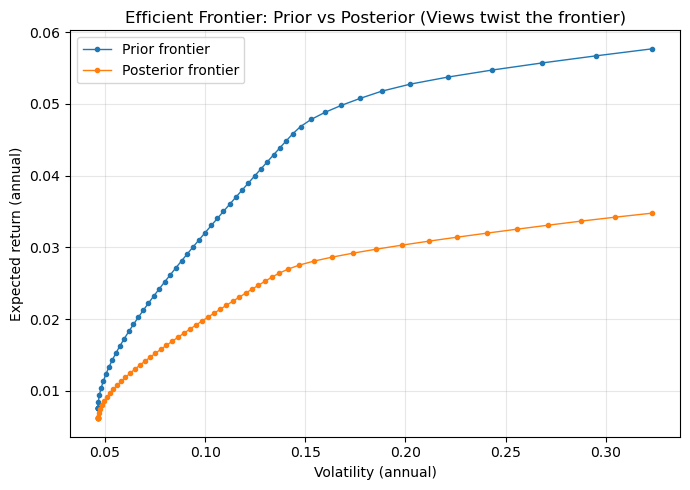

In [38]:
asset_names = ASSETS
mu_prior_vec = Pi_s.reindex(ASSETS).values          # or CMA-based priors
mu_post_vec  = mu_bl_s.reindex(ASSETS).values       # BL posterior
Sigma_use = Sigma_factor.reindex(index=ASSETS, columns=ASSETS).values

fr_prior, W_prior, fr_post, W_post = plot_twisted_frontiers(mu_prior_vec, mu_post_vec, Sigma_use, ASSETS)


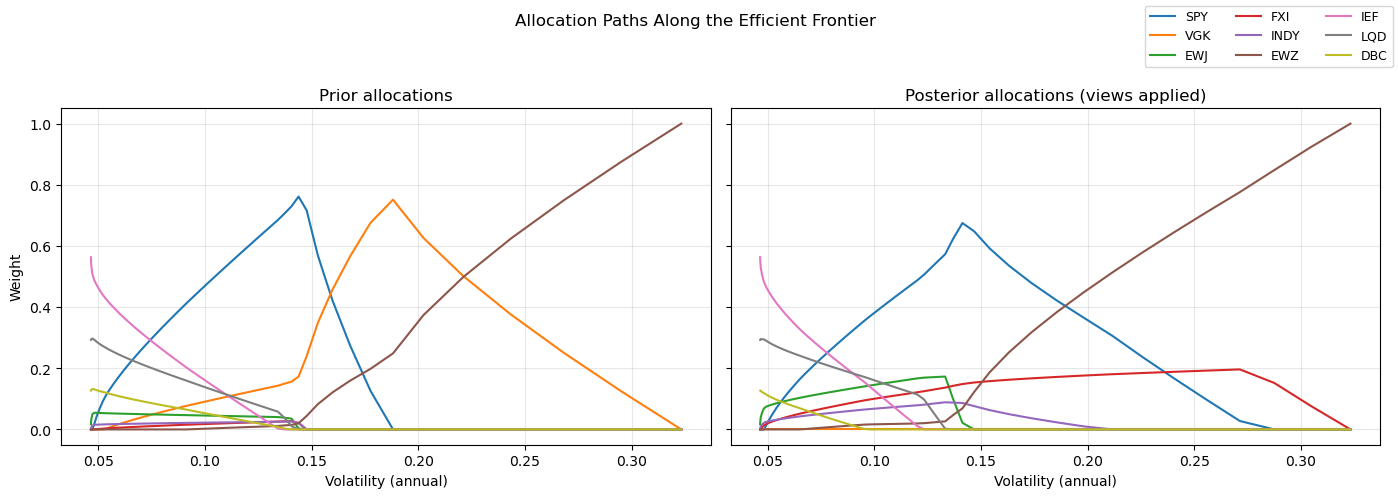

In [39]:
def plot_weights_vs_vol(fr_prior, W_prior,
                                     fr_post,  W_post,
                                     asset_names, title_left, title_right):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # ---- Prior ----
    ax = axes[0]
    for i, a in enumerate(asset_names):
        ax.plot(fr_prior["vol"], W_prior[:, i], label=a)
    ax.set_title(title_left)
    ax.set_xlabel("Volatility (annual)")
    ax.set_ylabel("Weight")
    ax.grid(True, alpha=0.3)

    # ---- Posterior ----
    ax = axes[1]
    for i, a in enumerate(asset_names):
        ax.plot(fr_post["vol"], W_post[:, i], label=a)
    ax.set_title(title_right)
    ax.set_xlabel("Volatility (annual)")
    ax.grid(True, alpha=0.3)

    # Shared legend (cleaner)
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=3, fontsize=9, loc="upper right")

    fig.suptitle("Allocation Paths Along the Efficient Frontier", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_weights_vs_vol(
    fr_prior, W_prior,
    fr_post,  W_post,
    ASSETS,
    "Prior allocations",
    "Posterior allocations (views applied)"
)

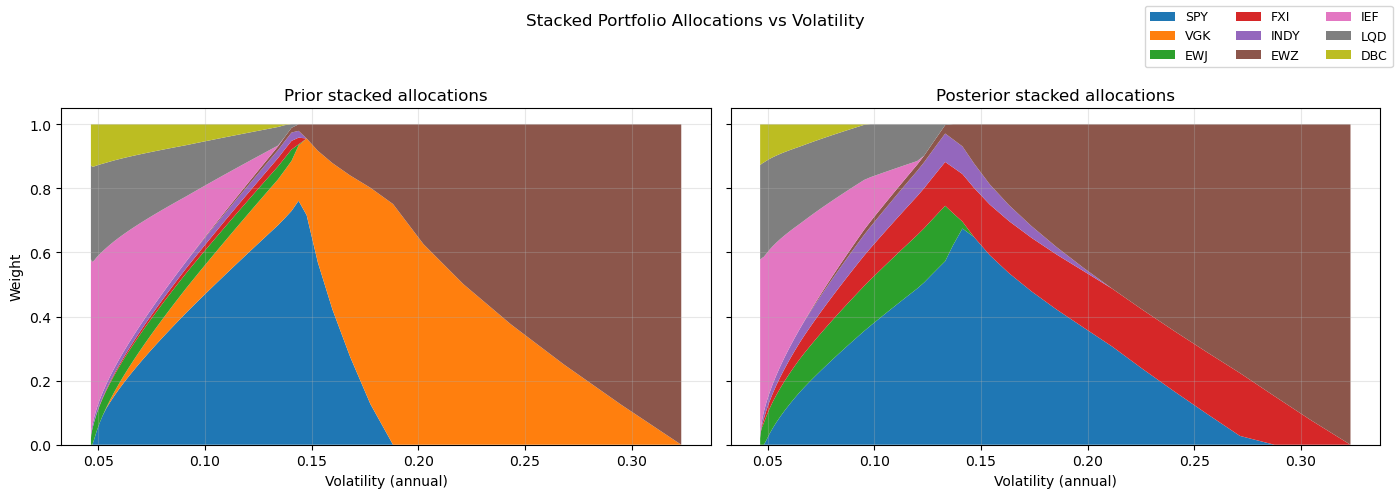

In [40]:
def plot_stacked_weights(fr_prior, W_prior,
                                      fr_post,  W_post,
                                      asset_names, title_left, title_right):

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    # ---- Prior ----
    axes[0].stackplot(fr_prior["vol"], W_prior.T, labels=asset_names)
    axes[0].set_title(title_left)
    axes[0].set_xlabel("Volatility (annual)")
    axes[0].set_ylabel("Weight")
    axes[0].grid(True, alpha=0.3)

    # ---- Posterior ----
    axes[1].stackplot(fr_post["vol"], W_post.T, labels=asset_names)
    axes[1].set_title(title_right)
    axes[1].set_xlabel("Volatility (annual)")
    axes[1].grid(True, alpha=0.3)

    # Shared legend (single, compact)
    handles, labels = axes[1].get_legend_handles_labels()
    fig.legend(handles, labels, ncol=3, fontsize=9, loc="upper right")

    fig.suptitle("Stacked Portfolio Allocations vs Volatility", fontsize=12)
    fig.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()

plot_stacked_weights(
    fr_prior, W_prior,
    fr_post,  W_post,
    ASSETS,
    "Prior stacked allocations",
    "Posterior stacked allocations"
)

### 05) Robustness, Risk Contributions, Portfolio weights allocation across multiple optimization constraints

#### 5a) Common helpers (risk, RC/ENB, turnover, costs)

In [41]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

PER_YEAR = 12

def port_vol(w, Sigma):
    w = np.asarray(w).reshape(-1)
    S = np.asarray(Sigma)
    return float(np.sqrt(w @ S @ w))

def port_ret(w, mu):
    w = np.asarray(w).reshape(-1)
    m = np.asarray(mu).reshape(-1)
    return float(m @ w)

def ann_stats(r_m):
    ann_ret = r_m.mean() * PER_YEAR
    ann_vol = r_m.std(ddof=1) * np.sqrt(PER_YEAR)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    wealth = (1 + r_m).cumprod()
    dd = wealth / wealth.cummax() - 1
    return pd.Series({"ann_ret": ann_ret, "ann_vol": ann_vol, "sharpe": sharpe, "max_dd": dd.min()})

def risk_contributions(w, Sigma):
    w = np.asarray(w).reshape(-1)
    S = np.asarray(Sigma)
    pv = port_vol(w, S)
    mrc = (S @ w) / pv
    rc = w * mrc
    prc = rc / rc.sum()
    return pd.Series(prc, index=ASSETS, name="pct_risk_contrib")

def effective_number_of_bets(w, Sigma):
    prc = risk_contributions(w, Sigma).values
    return float(1.0 / np.sum(prc**2))

def turnover(w_new, w_old):
    if w_old is None:
        return 0.0
    return float(np.sum(np.abs(np.asarray(w_new) - np.asarray(w_old))))

def apply_tc(r, to, tc_bps=10):
    # tc_bps per 1.0 turnover
    return r - (tc_bps / 1e4) * to


#### 5b) Multiple “indices of satisfaction”  Optimizers: MV, Max Sharpe, MinVar, MinVaR (parametric)

In [42]:
def opt_mean_variance(mu, Sigma, long_only=True, w_max=None, w0=None, l2_reg=0.0):
    mu = np.asarray(mu).reshape(-1)
    S = np.asarray(Sigma)
    n = len(mu)
    w = cp.Variable(n)

    base = mu @ w - 0.5 * cp.quad_form(w, S)
    if l2_reg > 0 and w0 is not None:
        base = base - l2_reg * cp.sum_squares(w - np.asarray(w0).reshape(-1))

    cons = [cp.sum(w) == 1]
    if long_only: cons += [w >= 0]
    if w_max is not None: cons += [w <= np.asarray(w_max)]

    cp.Problem(cp.Maximize(base), cons).solve(solver=cp.OSQP, verbose=False)
    return np.asarray(w.value).reshape(-1)

def opt_min_var(Sigma, long_only=True, w_max=None):
    S = np.asarray(Sigma)
    n = S.shape[0]
    w = cp.Variable(n)
    cons = [cp.sum(w) == 1]
    if long_only: cons += [w >= 0]
    if w_max is not None: cons += [w <= np.asarray(w_max)]
    cp.Problem(cp.Minimize(cp.quad_form(w, S)), cons).solve(solver=cp.OSQP, verbose=False)
    return np.asarray(w.value).reshape(-1)

def opt_max_sharpe(mu, Sigma, long_only=True, w_max=None):
    """
    Maximize mu'w subject to:
      sum(w)=1
      w' Sigma w <= 1
      (optional) bounds
    This is a QCQP -> requires a conic solver (SCS or ECOS).
    """
    mu = np.asarray(mu).reshape(-1)
    S = np.asarray(Sigma)
    n = len(mu)

    w = cp.Variable(n)

    cons = [cp.sum(w) == 1, cp.quad_form(w, S) <= 1]
    if long_only:
        cons += [w >= 0]
    if w_max is not None:
        cons += [w <= np.asarray(w_max)]

    prob = cp.Problem(cp.Maximize(mu @ w), cons)

    # Try SCS first (widely available). ECOS also works if installed.
    try:
        prob.solve(solver=cp.SCS, verbose=False)
    except Exception:
        prob.solve(solver=cp.ECOS, verbose=False)

    if w.value is None:
        raise RuntimeError("MaxSharpe solver failed (no solution returned).")

    return np.asarray(w.value).reshape(-1)


def opt_min_param_var(mu, Sigma, alpha=0.05, long_only=True, w_max=None):
    from scipy.stats import norm
    z = float(norm.ppf(1 - alpha))  # 1.645 for 5%
    mu = np.asarray(mu).reshape(-1)
    S = np.asarray(Sigma)
    n = len(mu)
    w = cp.Variable(n)

    # minimize z * sqrt(w' S w) - mu'w
    L = np.linalg.cholesky(S + 1e-10*np.eye(n))
    obj = cp.Minimize(z * cp.norm(L @ w, 2) - mu @ w)

    cons = [cp.sum(w) == 1]
    if long_only: cons += [w >= 0]
    if w_max is not None: cons += [w <= np.asarray(w_max)]

    cp.Problem(obj, cons).solve(solver=cp.SCS, verbose=False)
    return np.asarray(w.value).reshape(-1)


#### 5c) Tracking Error optimization (benchmark-relative) TE Minimization and TE metrics 

In [43]:
def opt_min_tracking_error(Sigma, w_bench, long_only=True, w_max=None):
    S = np.asarray(Sigma)
    wb = np.asarray(w_bench).reshape(-1)
    n = len(wb)
    w = cp.Variable(n)

    obj = cp.Minimize(cp.quad_form(w - wb, S))
    cons = [cp.sum(w) == 1]
    if long_only: cons += [w >= 0]
    if w_max is not None: cons += [w <= np.asarray(w_max)]

    cp.Problem(obj, cons).solve(solver=cp.OSQP, verbose=False)
    return np.asarray(w.value).reshape(-1)

def tracking_error(w, w_bench, Sigma):
    a = np.asarray(w) - np.asarray(w_bench)
    return float(np.sqrt(a @ np.asarray(Sigma) @ a))


#### 5d) Robust Σ: add EWMA covariance (in addition to factor and LedoitWolf)

In [44]:
def ewma_cov(returns_m: pd.DataFrame, lam=0.94):
    X = returns_m.values
    T, n = X.shape
    S = np.zeros((n, n))
    w = 1.0
    wsum = 0.0
    for t in range(T-1, -1, -1):
        xt = X[t:t+1].T
        S += w * (xt @ xt.T)
        wsum += w
        w *= lam
    S = S / wsum
    return pd.DataFrame(S, index=returns_m.columns, columns=returns_m.columns)

# Example robust Σ
Sigma_ewma = ewma_cov(rets.loc[:, ASSETS], lam=0.94) * PER_YEAR


#### 5e) Corner-solution mitigation: caps + regularization toward benchmark

In [45]:
# Example caps (tune to your mandate)
w_max = np.array([0.65, 0.35, 0.20, 0.20, 0.20, 0.15, 0.20, 0.20, 0.10])  # per asset max weights

w_bench = w_mkt.reindex(ASSETS).values  # benchmark vector


#### 5f) Risk contributions + ENB summary tables

In [46]:
def summarize(name, w, mu, Sigma, w_bench=None):
    s = {
        "ret": port_ret(w, mu),
        "vol": port_vol(w, Sigma),
        "enb": effective_number_of_bets(w, Sigma)
    }
    if w_bench is not None:
        s["TE"] = tracking_error(w, w_bench, Sigma)
    return pd.Series(s, name=name), risk_contributions(w, Sigma)


#### 5g) compute portfolios across objectives and Σ variants

In [47]:
mu_prior = Pi_s.reindex(ASSETS).values
mu_post  = mu_bl_s.reindex(ASSETS).values

Sigmas = {
    "Factor": Sigma_factor.loc[ASSETS, ASSETS].values,
    "LedoitWolf": Sigma_lw.loc[ASSETS, ASSETS].values,
    "EWMA": Sigma_ewma.loc[ASSETS, ASSETS].values
}

portfolios = []

for sname, S in Sigmas.items():
    # Baselines
    w_minv   = opt_min_var(S, w_max=w_max)
    w_mv     = opt_mean_variance(mu_post, S, w_max=w_max)
    w_sh     = opt_max_sharpe(mu_post, S, w_max=w_max)
    w_var    = opt_min_param_var(mu_post, S, alpha=0.05, w_max=w_max)

    # Benchmark-relative
    w_te     = opt_min_tracking_error(S, w_bench=w_bench, w_max=w_max)

    # Stabilized BL (regularized toward benchmark)
    w_mv_reg = opt_mean_variance(mu_post, S, w_max=w_max, w0=w_bench, l2_reg=5.0)

    for (nm, w) in [
        ("Min_Var", w_minv),
        ("MV_BL", w_mv),
        ("MaxSharpe_BL", w_sh),
        ("Min_VaR_5%_BL", w_var),
        ("Min_TE", w_te),
        ("MV_BL_Reg", w_mv_reg),
    ]:
        name = f"{nm}_{sname}"
        summary, rc = summarize(name, w, mu_post, S, w_bench=w_bench)
        portfolios.append((summary, rc, w))

# ---- Build output DataFrames ----
summary_df = pd.DataFrame([p[0] for p in portfolios])
summary_df.index.name = "portfolio"

weights_df = pd.DataFrame(
    {p[0].name: p[2] for p in portfolios},
    index=ASSETS
).T
weights_df.index.name = "portfolio"

rc_df = pd.DataFrame(
    {p[0].name: p[1].values for p in portfolios},
    index=ASSETS
).T
rc_df.index.name = "portfolio"

# ---- Save ----
summary_df.to_csv(OUT_DIR / "portfolio_summaries_diff_opt.csv")
weights_df.to_csv(OUT_DIR / "portfolio_weights_diff_opt.csv")
rc_df.to_csv(OUT_DIR / "portfolio_risk_contrib_diff_opt.csv")


#### 5h) Portfolio backtesting vs factors

Regressing results of BL_MV portfolio on factors

In [48]:
def regress_portfolio_on_factors(port_ret_, rf, F_reg):
    """
    port_ret: Series monthly simple returns
    rf: Series monthly simple returns (risk-free)
    F_reg: DataFrame of factor returns (same frequency)
    """
    idx = port_ret_.index.intersection(rf.index).intersection(F_reg.index)
    y = (port_ret_.loc[idx] - rf.loc[idx]).rename("port_excess")
    X = sm.add_constant(F_reg.loc[idx])
    res = sm.OLS(y.values, X.values).fit()

    betas = pd.Series(res.params, index=["alpha"] + list(F_reg.columns))
    stats = pd.Series({
        "alpha_monthly": float(res.params[0]),
        "alpha_annual":  float(res.params[0] * PER_YEAR),
        "R2":            float(res.rsquared),
        "Ann.Vol":       float(y.std(ddof=1) * np.sqrt(PER_YEAR)),
        "Ann.Return":    float(y.mean() * PER_YEAR),
        "Sharpe":        float((y.mean() * PER_YEAR) / (y.std(ddof=1) * np.sqrt(PER_YEAR)))
    })
    return betas, stats, res

# Example (replace port_ret_series with your computed portfolio returns):
# betas, stats, res = regress_portfolio_on_factors(port_ret_series, rf_m2, F_bt)
# betas, stats

# Example: BL Mean–Variance portfolio (Factor covariance)
w = weights_df.loc["MV_BL_Factor"].values   # or directly w_mv

port_ret_f = rets.loc[:, ASSETS] @ w
port_ret_f.name = "MV_BL_Factor"

factor_cols = ["MKT_RF", "SMB", "HML", "MOM", "TERM", "CREDIT", "COM"]
F_reg = F_bt[factor_cols]

betas, stats, res = regress_portfolio_on_factors(
    port_ret_=port_ret_f,
    rf=rf_m2,
    F_reg=F_reg
)

# display(betas)
# display(stats)
print(res.summary())

betas.to_csv(OUT_DIR / "mv_bl_factor_betas.csv")
stats.to_csv(OUT_DIR / "mv_bl_factor_stats.csv")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     255.5
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           3.33e-91
Time:                        12:15:23   Log-Likelihood:                 573.55
No. Observations:                 192   AIC:                            -1131.
Df Residuals:                     184   BIC:                            -1105.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.959      0.0

In [49]:
w = weights_df.loc["Min_Var_Factor"].values   # or directly w_mv

port_ret_f = rets.loc[:, ASSETS] @ w
port_ret_f.name = "Min_Var_Factor"

factor_cols = ["MKT_RF", "SMB", "HML", "MOM", "TERM", "CREDIT", "COM"]
F_reg = F_bt[factor_cols]

betas, stats, res = regress_portfolio_on_factors(
    port_ret_=port_ret_f,
    rf=rf_m2,
    F_reg=F_reg
)

# display(betas)
# display(stats)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     106.4
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           3.07e-61
Time:                        12:15:23   Log-Likelihood:                 597.54
No. Observations:                 192   AIC:                            -1179.
Df Residuals:                     184   BIC:                            -1153.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0009      0.001     -1.070      0.2

In [50]:
w = weights_df.loc["Min_TE_Factor"].values   # or directly w_mv

port_ret_f = rets.loc[:, ASSETS] @ w
port_ret_f.name = "Min_TE_Factor"

factor_cols = ["MKT_RF", "SMB", "HML", "MOM", "TERM", "CREDIT", "COM"]
F_reg = F_bt[factor_cols]

betas, stats, res = regress_portfolio_on_factors(
    port_ret_=port_ret_f,
    rf=rf_m2,
    F_reg=F_reg
)

# display(betas)
# display(stats)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     547.5
Date:                Mon, 23 Feb 2026   Prob (F-statistic):          1.48e-119
Time:                        12:15:24   Log-Likelihood:                 684.56
No. Observations:                 192   AIC:                            -1353.
Df Residuals:                     184   BIC:                            -1327.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.001     -2.297      0.0

In [51]:
w = weights_df.loc["MV_BL_LedoitWolf"].values   # or directly w_mv

port_ret_f = rets.loc[:, ASSETS] @ w
port_ret_f.name = "MV_BL_LedoitWolf"

factor_cols = ["MKT_RF", "SMB", "HML", "MOM", "TERM", "CREDIT", "COM"]
F_reg = F_bt[factor_cols]

betas, stats, res = regress_portfolio_on_factors(
    port_ret_=port_ret_f,
    rf=rf_m2,
    F_reg=F_reg
)

# display(betas)
# display(stats)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     265.9
Date:                Mon, 23 Feb 2026   Prob (F-statistic):           1.20e-92
Time:                        12:15:24   Log-Likelihood:                 576.89
No. Observations:                 192   AIC:                            -1138.
Df Residuals:                     184   BIC:                            -1112.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019      0.001     -1.972      0.0

#### 5i) Risk Contribution and Plots

C:\Users\ANJESHNU\AppData\Local\Temp\ipykernel_15232\428775773.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(rc_plot_pct.columns, rotation=30, ha="right")


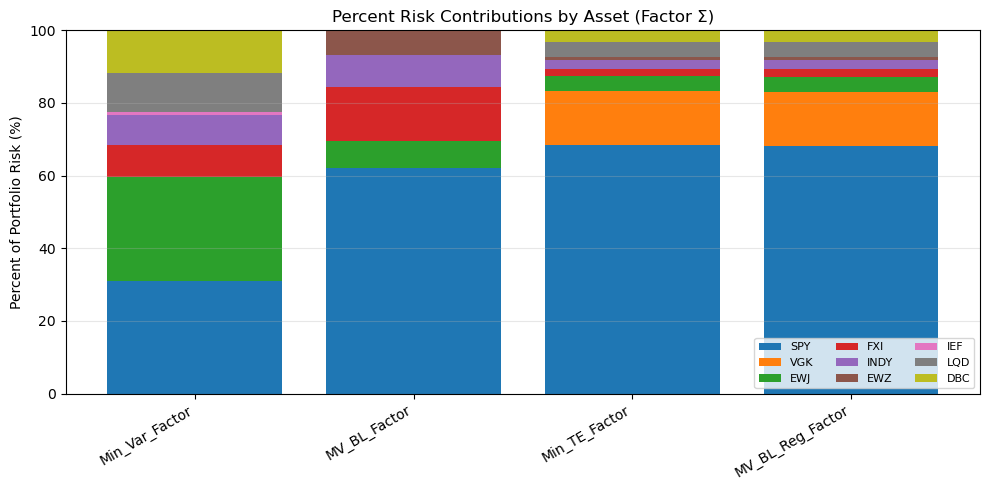

In [52]:
# --- Collect weights and risk contributions into DataFrames (tidy outputs) ---
weights_df = pd.DataFrame(
    {p[0].name: p[2] for p in portfolios},
    index=ASSETS
)

rc_df = pd.DataFrame(
    {p[0].name: p[1].values for p in portfolios},
    index=ASSETS
)


# Stacked bar chart: % risk contributions
def pick_cols(df, contains=("Factor",), names=("MV_BL", "Min_Var", "MV_BL_Reg", "Min_TE")):
    cols = []
    for c in df.columns:
        if all(s in c for s in contains) and any(n in c for n in names):
            cols.append(c)
    return cols

rc_cols = pick_cols(rc_df, contains=("Factor",), names=("MV_BL", "Min_Var", "MV_BL_Reg", "Min_TE"))
rc_plot = rc_df[rc_cols].copy()

# convert to %
rc_plot_pct = rc_plot * 100.0

fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(rc_plot_pct.columns))

for a in ASSETS:
    vals = rc_plot_pct.loc[a].values
    ax.bar(rc_plot_pct.columns, vals, bottom=bottom, label=a)
    bottom += vals

ax.set_title("Percent Risk Contributions by Asset (Factor Σ)")
ax.set_ylabel("Percent of Portfolio Risk (%)")
ax.set_xticklabels(rc_plot_pct.columns, rotation=30, ha="right")
ax.grid(True, axis="y", alpha=0.3)
ax.legend(ncols=3, fontsize=8, loc="lower right")
plt.tight_layout()
plt.show()

save_fig(fig, "fig_4_4_risk_contrib_stacked_bar_factor")


# Pull ENB for the same selected portfolios
enb_tbl = summary_df.set_index(summary_df.index)[["enb"]].copy()
enb_tbl = enb_tbl.loc[rc_cols].rename(columns={"enb":"Effective Number of Bets"})
enb_tbl.to_csv(OUT_DIR / "enb_rc.csv")


#### 5j) Risk Aversion Estimation and Implied Risk Premiums and Plots

In [53]:
# Compute Trustee / Market / Kelly portfolios + stats
risk_profiles = {
    "Trustee (High λ)": 10.0,
    "Market (Mid λ)":    3.0,
    "Kelly (Low λ)":     1.0,
}

S_base = Sigma_factor.loc[ASSETS, ASSETS].values

rp_weights = {}
rp_stats = []
rp_rc = {}

for nm, lam in risk_profiles.items():
    S_scaled = lam * S_base
    w_rp = opt_mean_variance(mu_post, S_scaled, w_max=w_max, w0=w_bench, l2_reg=0.0)  # MV on scaled risk
    rp_weights[nm] = w_rp
    rp_rc[nm] = risk_contributions(w_rp, S_base)   # compute RC on base Sigma (not scaled)
    
    st, _ = summarize(nm, w_rp, mu_post, S_base, w_bench=w_bench)
    rp_stats.append(st)

rp_w_df = pd.DataFrame(rp_weights, index=ASSETS)
rp_stats_df = pd.DataFrame(rp_stats)

display(rp_w_df)
display(rp_stats_df)

rp_w_df.to_csv(OUT_DIR / "risk_profile_weights.csv")
rp_stats_df.to_csv(OUT_DIR / "risk_profile_stats.csv")


,Trustee (High λ),Market (Mid λ),Kelly (Low λ)
SPY,1.925306e-01,2.406446e-01,6.246324e-01
VGK,2.754370e-23,-8.365356e-23,-7.762468e-23
EWJ,2.000000e-01,1.640287e-01,9.737143e-02
FXI,5.613426e-02,6.882191e-02,1.427389e-01
INDY,5.133518e-02,5.338935e-02,8.765491e-02
EWZ,1.061767e-23,-7.368247e-24,4.760235e-02
IEF,2.000000e-01,2.000000e-01,3.596608e-23
LQD,2.000000e-01,2.000000e-01,6.768850e-23
DBC,1.000000e-01,7.311544e-02,5.515460e-23


,ret,vol,enb,TE
Trustee (High λ),0.016144,0.080620,4.608092,0.042096
Market (Mid λ),0.016595,0.082234,4.270535,0.039046
Kelly (Low λ),0.026428,0.137070,2.341875,0.041161


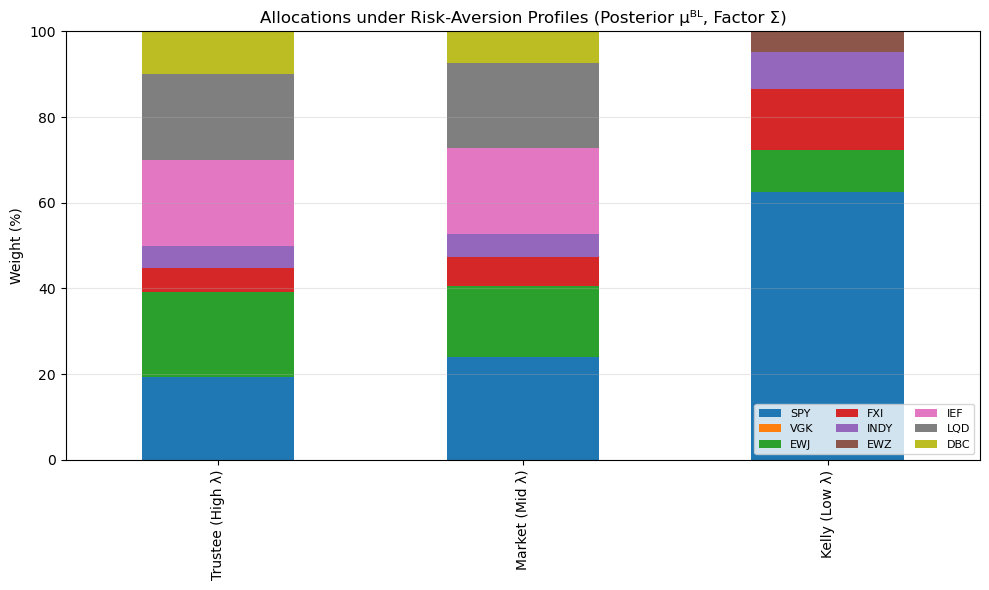

In [54]:
# Plot risk-profile allocations (one clean bar plot)
fig, ax = plt.subplots(figsize=(10, 6))
(rp_w_df * 100).T.plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Allocations under Risk-Aversion Profiles (Posterior μᴮᴸ, Factor Σ)")
ax.set_ylabel("Weight (%)")
ax.legend(ncols=3, fontsize=8, loc="lower right")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

save_fig(fig, "fig_4_8_risk_profiles_allocations")


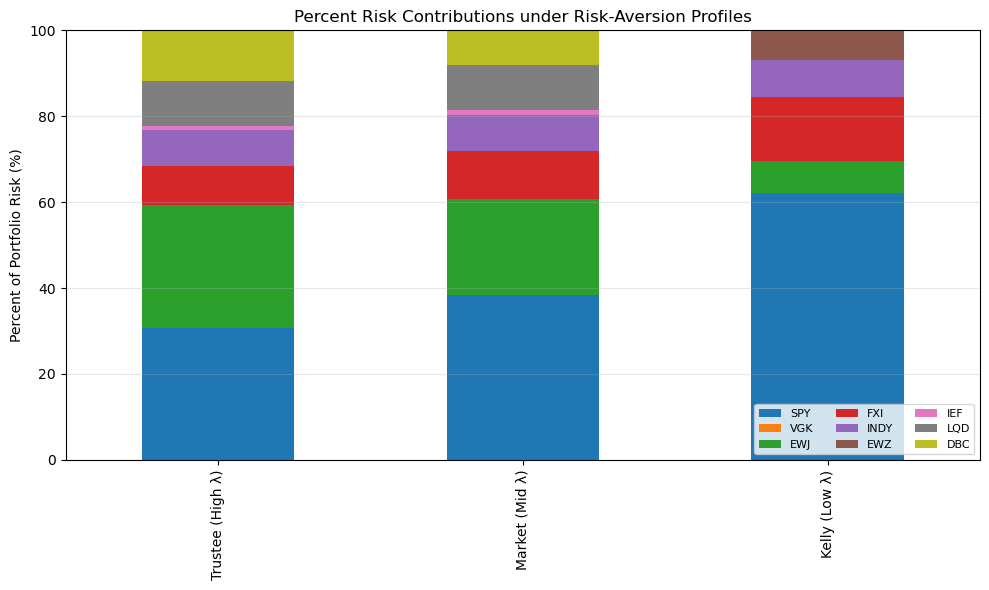

In [55]:
# Risk-profile risk contributions (optional, but strong)
rp_rc_df = pd.DataFrame(rp_rc) * 100

fig, ax = plt.subplots(figsize=(10, 6))
rp_rc_df.T.plot(kind="bar", stacked=True, ax=ax)
ax.set_title("Percent Risk Contributions under Risk-Aversion Profiles")
ax.set_ylabel("Percent of Portfolio Risk (%)")
ax.legend(ncols=3, fontsize=8, loc="lower right")
ax.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

save_fig(fig, "fig_4_9_risk_profiles_risk_contrib")


#### 5k) Sensitivity: τ and Ω scaling (robustness of views)

In [56]:
def omega_scale(Omega, scale):
    return Omega * scale  # higher = less confident

taus = [0.01, 0.05, 0.10]
omega_scales = [0.1, 0.5, 1.0, 2.0]  # 0.5 more confident, 2 less confident

rows = []
for tau in taus:
    for os in omega_scales:
        Pi_tmp, mu_tmp, _ = black_litterman(Sigmas["Factor"], w_bench, lambda_imp, P, Q, omega_scale(Omega, os), tau)
        w_tmp = opt_mean_variance(mu_tmp, Sigmas["Factor"], w_max=w_max)
        rows.append({"tau": tau, "omega_scale": os, **{a: w_tmp[i] for i,a in enumerate(ASSETS)}})

sens_w = pd.DataFrame(rows)
sens_w.to_csv(OUT_DIR / "sensitivity_weights.csv", index=False)
sens_w



,tau,omega_scale,SPY,VGK,EWJ,FXI,INDY,EWZ,IEF,LQD,DBC
0,0.01,0.1,3.559622e-01,-6.898646e-23,1.516008e-01,2.000000e-01,0.150789,0.078939,5.170246e-23,6.270894e-02,-1.058040e-23
1,0.01,0.5,6.500000e-01,-3.101448e-22,1.391464e-01,7.525469e-02,0.075952,0.059647,-7.484942e-23,-5.382421e-23,-7.581554e-23
2,0.01,1.0,6.500000e-01,7.681116e-02,9.327766e-02,3.742727e-02,0.066543,0.075941,-1.590697e-22,-3.082660e-23,1.881606e-24
3,0.01,2.0,6.500000e-01,2.458300e-01,-9.202285e-23,-3.881783e-23,0.025780,0.078390,5.051308e-23,8.827001e-23,-9.281923e-24
4,0.05,0.1,2.637879e-23,-2.030367e-23,9.372138e-03,2.000000e-01,0.200000,0.139891,1.507373e-01,2.000000e-01,1.000000e-01
5,0.05,0.5,3.559622e-01,-9.073122e-23,1.516008e-01,2.000000e-01,0.150789,0.078939,6.369236e-23,6.270894e-02,-4.126818e-23
6,0.05,1.0,6.246324e-01,-1.091254e-22,9.737143e-02,1.427389e-01,0.087655,0.047602,-3.864850e-23,-7.722239e-23,2.000327e-23
7,0.05,2.0,6.500000e-01,-2.035010e-22,1.323262e-01,8.819692e-02,0.075855,0.053622,-5.652309e-23,-8.294254e-23,-5.016378e-23
8,0.10,0.1,9.653109e-23,7.763008e-23,1.642130e-23,2.000000e-01,0.200000,0.138579,1.614211e-01,2.000000e-01,1.000000e-01
9,0.10,0.5,8.440834e-02,-1.235213e-22,1.232835e-01,2.000000e-01,0.191763,0.100545,-1.171562e-22,2.000000e-01,1.000000e-01
